In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

nba = pd.read_csv('nba_2013.csv',encoding='ISO8859-1')
print(nba.head())

          player pos  age bref_team_id   g  gs    mp   fg   fga    fg.  \
0     Quincy Acy  SF   23          TOT  63   0   847   66   141  0.468   
1   Steven Adams   C   20          OKC  81  20  1197   93   185  0.503   
2    Jeff Adrien  PF   27          TOT  53  12   961  143   275  0.520   
3  Arron Afflalo  SG   28          ORL  73  73  2552  464  1011  0.459   
4  Alexis Ajinca   C   25          NOP  56  30   951  136   249  0.546   

      ...      drb  trb  ast  stl  blk  tov   pf   pts     season  season_end  
0     ...      144  216   28   23   26   30  122   171  2013-2014        2013  
1     ...      190  332   43   40   57   71  203   265  2013-2014        2013  
2     ...      204  306   38   24   36   39  108   362  2013-2014        2013  
3     ...      230  262  248   35    3  146  136  1330  2013-2014        2013  
4     ...      183  277   40   23   46   63  187   328  2013-2014        2013  

[5 rows x 31 columns]


In NBA media coverage, sports reporters usually focus on a handful of players and paint stories of how unique these players' stats are. With our data science hats on, we can't help but feel a slight sense of skepticism to how different the players are from one another. Let's see how we can use data science to explore that thread further.

Let's look at the dataset of player performance from the 2013-2014 season.

Here are some selected columns:

player -- name of the player
pos -- the position of the player
g -- number of games the player was in
pts -- total points the player scored
fg. -- field goal percentage
ft. -- free throw percentage

Point guards play one of the most crucial roles on a team because their primary responsibility is to create scoring opportunities for the team. We are going to focus our lesson on a machine learning technique called clustering, which allows us to visualize the types of point guards as well as group similar point guards together. Using 2 features allows us to easily visualize the players and will also make it easier to grasp how clustering works. For point guards, it's widely accepted that the Assist to Turnover Ratio is a good indicator for performance in games as it quantifies the number of scoring opportunities that player created. Let's also use Points Per Game, since effective Point Guards not only set up scoring opportunities but also take a lot of the shots themselves.

In [2]:
point_guards = nba[nba['pos'] == 'PG']
print(point_guards.head(3))

             player pos  age bref_team_id   g  gs    mp   fg  fga    fg.  \
24    D.J. Augustin  PG   26          TOT  71   9  1939  298  718  0.415   
29  Leandro Barbosa  PG   31          PHO  20   0   368   56  131  0.427   
30       Jose Barea  PG   29          MIN  79   1  1471  254  656  0.387   

       ...      drb  trb  ast  stl  blk  tov   pf  pts     season  season_end  
24     ...      115  130  313   53    3  125  147  930  2013-2014        2013  
29     ...       32   37   32    7    4   19   30  150  2013-2014        2013  
30     ...      138  154  303   26    0  125  129  660  2013-2014        2013  

[3 rows x 31 columns]


While our dataset doesn't come with Points Per Game values, we can easily calculate those using each player's total points (pts) and the number of games (g) they played. Let's take advantage of pandas' ability to multiply and divide columns to create the Points Per Game ppg column by dividing the pts and g columns.

In [3]:
point_guards['ppg'] = point_guards['pts'] / point_guards['g']

print(point_guards[['ppg','pts','g']].head(3))

          ppg  pts   g
24  13.098592  930  71
29   7.500000  150  20
30   8.354430  660  79


/Users/kunalbarde/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Now let's create a column, atr, for the Assist Turnover Ratio, which is calculated by dividing total assists (ast) by total turnovers (tov):

ATR = Assists / Turnovers

In [4]:
point_guards = point_guards[point_guards['tov'] != 0]

point_guards['atr'] = point_guards['ast'] / point_guards['tov']

Using matplotlib to create a scatter plot with Points Per Game (ppg) on the X axis and Assist Turnover Ratio (atr) on the Y axis.

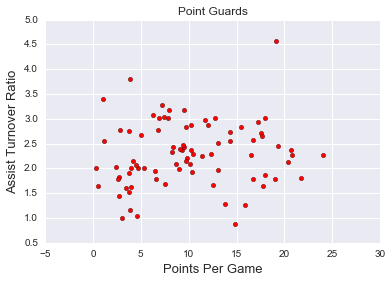

In [5]:
plt.scatter(point_guards['ppg'], point_guards['atr'], c='r')
plt.title("Point Guards")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)

There seem to be 5 general regions, or clusters, that the point guards fall into (with a few outliers of course!). We can use a technique called clustering to segment all of the point guards into groups of alike players. While regression and other supervised machine learning techniques work well when we have a clear metric we want to optimize for and lots of pre-labelled data, we need to instead use unsupervised machine learning techniques to explore the structure within a data set that doesn't have a clear value to optimize.

There are multiple ways of clustering data but here we will focus on centroid based clustering for this lesson. Centroid based clustering works well when the clusters resemble circles with centers (or centroids). The centroid represent the arithmetic mean of all of the data points in that cluster.

K-Means Clustering is a popular centroid-based clustering algorithm that we will use. The K in K-Means refers to the number of clusters we want to segment our data into. The key part with K-Means (and most unsupervised machine learning techniques) is that we have to specify what k is. There are advantages and disadvantages to this, but one advantage is that we can pick the k that makes the most sense for our use case. We'll set k to 5 since we want K-Means to segment our data into 5 clusters.

The Algorithm:

Select 5 players at random and assign their coordinates as the initial centroids of the just created clusters.

Step 1 (Assign Points to Clusters) For each player, calculate the Euclidean distance between that player's coordinates, or values for atr & ppg, and each of the centroids' coordinates. Assign the player to the cluster whose centroid is the closest to, or has the lowest Euclidean distance to, the player's values.

Step 2 (Update New Centroids of the Clusters) For each cluster, compute the new centroid by calculating the arithmetic mean of all of the points (players) in that cluster. We calculate the arithmetic mean by taking the average of all of the X values (atr) and the average of all of the Y values (ppg) of the points in that cluster.

Iterate Repeat steps 1 & 2 until the clusters are no longer moving and have converged.

In [6]:
num_clusters = 5

random_initial_points = np.random.choice(point_guards.index, size=num_clusters)

centroids = point_guards.loc[random_initial_points]

Let's plot the centroids, in addition to the point_guards, so we can see where the randomly chosen centroids started out.

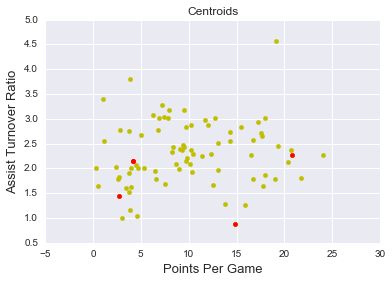

In [7]:
plt.scatter(point_guards['ppg'], point_guards['atr'],color='y')
plt.scatter(centroids['ppg'], centroids['atr'],color='r')
plt.title('Centroids')
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

While the centroids data frame object worked well for the initial centroids, where the centroids were just a subset of players, as we iterate the centroids' values will be coordinates that may not match another player's coordinates. Moving forward, let's use a dictionary object instead to represent the centroids.

We will need a unique identifier, like cluster_id, to refer to each cluster's centroid and a list representation of the centroid's coordinates (or values for ppg and atr). Let's create a dictionary then with the following mapping:

key: cluster_id of that centroid's cluster
value: centroid's coordinates expressed as a list ( ppg value first, atr value second )
To generate the cluster_ids, let's iterate through each centroid and assign an integer from 0 to k-1. For example, the first centroid will have a cluster_id of 0, while the second one will have a cluster_id of 1. We'll write a function, centroids_to_dict, that takes in the centroids data frame object, creates a cluster_id and converts the ppg and atr values for that centroid into a list of coordinates, and adds both the cluster_id and coordinates_list into the dictionary that's returned.

In [8]:
def centroids_to_dict(centroids):
    dictionary = dict()
    counter = 0
    
    for index,row in centroids.iterrows():
        coordinates = [row['ppg'],row['atr']]
        dictionary[counter] = coordinates
        counter += 1
        
    return dictionary

centroids_dict = centroids_to_dict(centroids)
print(centroids_dict)

{0: [4.133333333333334, 2.142857142857143], 1: [20.816901408450704, 2.278947368421053], 2: [2.7450980392156863, 1.4411764705882353], 3: [14.85, 0.8854166666666666], 4: [4.133333333333334, 2.142857142857143]}


Let's create the function calculate_distance, which takes in 2 lists (the player's values for ppg and atr and the centroid's values for ppg and atr).

In [9]:
import math

def calculate_distance(centroid, player_values):
    root_distance = 0
    
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[0]
        squared_difference = difference ** 2
        root_distance += squared_difference
        
    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

Now we need a way to assign data points to clusters based on Euclidean distance. Instead of creating a new variable or data structure to house the clusters, let's keep things simple and just add a column to the point_guards data frame that contains the cluster_id of the cluster it belongs to.

In [10]:
def assign_to_cluster(row):
    distances = []
    player_values = [row['ppg'],row['atr']]
    for centroid in centroids_dict:
        distance = calculate_distance(centroids_dict[centroid], player_values)
        distances.append(distance)
    least_distance = min(distances)
    least_index = distances.index(least_distance)
    return least_index

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
print(point_guards.head())

             player pos  age bref_team_id   g  gs    mp   fg  fga    fg.  \
24    D.J. Augustin  PG   26          TOT  71   9  1939  298  718  0.415   
29  Leandro Barbosa  PG   31          PHO  20   0   368   56  131  0.427   
30       Jose Barea  PG   29          MIN  79   1  1471  254  656  0.387   
38   Jerryd Bayless  PG   25          TOT  72  19  1686  248  617  0.402   
50      Steve Blake  PG   33          TOT  55  28  1498  133  353  0.377   

     ...     stl  blk  tov   pf  pts     season  season_end        ppg  \
24   ...      53    3  125  147  930  2013-2014        2013  13.098592   
29   ...       7    4   19   30  150  2013-2014        2013   7.500000   
30   ...      26    0  125  129  660  2013-2014        2013   8.354430   
38   ...      60    9   82  161  666  2013-2014        2013   9.250000   
50   ...      54    8  102   85  378  2013-2014        2013   6.872727   

         atr  cluster  
24  2.504000        3  
29  1.684211        0  
30  2.424000        0  
38

Let's write a function, visualize_clusters, that we can use to visualize the clusters easily.

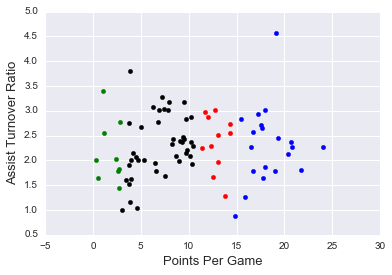

In [11]:
def visualize_clusters(df, num_clusters):
    colors =['b','g','r','c','m','y','k']
    
    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], color = colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)

visualize_clusters(point_guards, 5)
plt.show()

Let's code Step 2, where we recalculate the centroids for each cluster.

In [12]:
def recalculate_centroids(df):
    new_centroids_dict = dict()
    for cluster_id in range(0, num_clusters):
        clustered_df = df[df['cluster'] == cluster_id]
        new_coordinates = [clustered_df['ppg'].mean(), clustered_df['atr'].mean()]
        new_centroids_dict[cluster_id] = new_coordinates
    return new_centroids_dict

centroids_dict = recalculate_centroids(point_guards)
print(centroids_dict)

{0: [7.00765380992795, 2.2984458566532497], 1: [18.362214683064355, 2.3048103622888023], 2: [1.8103812636165582, 2.1621977917229724], 3: [12.851510593612359, 2.37482190856395], 4: [nan, nan]}


Now that we recalculated the centroids, let's re-run Step 1 (assign_to_cluster) and see how the clusters shifted.

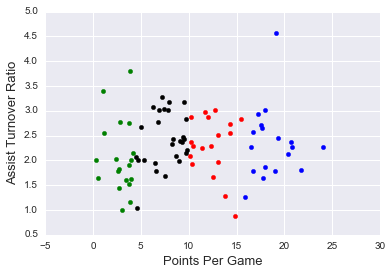

In [13]:
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

Now we need to recalculate the centroids, and shift the clusters again.

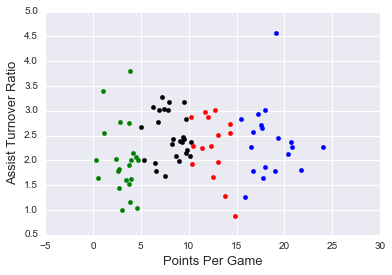

In [14]:
centroids_dict = recalculate_centroids(point_guards)
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

The clusters visually look like they don't move a lot after every iteration. This means 2 things:

K-Means doesn't cause massive changes in the makeup of clusters between iterations, meaning that it will always converge and become stable.
Because K-Means is conservative between iterations, where we pick the initial centroids and how we assign the players to clusters initially matters a lot.

To counteract these problems, the sklearn implementation of K-Means does some intelligent things like re-running the entire clustering process lots of times with random initial centroids so the final results are a little less biased on one passthrough's initial centroids.

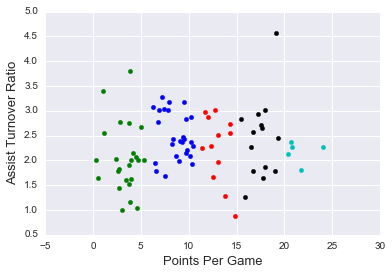

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg','atr']])
point_guards['cluster'] = kmeans.labels_

visualize_clusters(point_guards, num_clusters)